In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import matplotlib.ticker as mticker

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement).order_by(Measurement.id.desc()).first().date
year_ago = str(int(last_date[0:4])-1) + last_date[4:]

# Perform a query to retrieve the date and precipitation scores
past_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date.between(year_ago, last_date))
# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame(past_year).set_index('date')

# Sort the dataframe by date
grouped_df = prec_df.groupby('date').max()
grouped_df

,prcp
date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.56


Text(0, 0.5, 'Precipitation (in)')

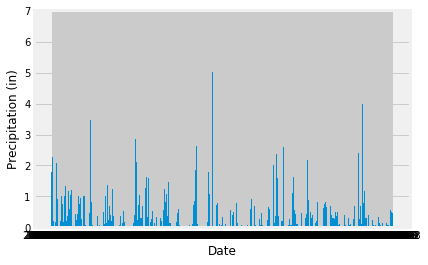

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(grouped_df.index, grouped_df['prcp'], align='center')
plt.xlabel('Date')
plt.ylabel('Precipitation (in)')

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
grouped_df.describe()

,prcp
count,366.000000
mean,0.520765
std,0.830728
min,0.000000
25%,0.040000
50%,0.250000
75%,0.672500
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).group_by(Measurement.station).all()
print(f'There are {len(stations)} in the dataset. They are:')
stations

There are 9 in the dataset. They are:


[('USC00511918'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00516128'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519281'),
 ('USC00519397'),
 ('USC00519523')]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activity = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = activity[0][0]
most_active
temperatures = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == most_active).all()
min_temp = temperatures[0][0]
max_temp = temperatures[0][1]
avg_temp = temperatures[0][2]
min_date = session.query(Measurement.date).filter(Measurement.station == most_active).filter(Measurement.tobs == min_temp)[0][0]
max_date = session.query(Measurement.date).filter(Measurement.station == most_active).filter(Measurement.tobs == max_temp)[0][0]
print(f'The lowest temperature recorded at {most_active} was {min_temp} on {min_date}.')
print(f'The highest temperature recorded at {most_active} was {max_temp} on {max_date}.')
print(f'The average temperature recorded at {most_active} was {avg_temp:.1f}.')

The lowest temperature recorded at USC00519281 was 54.0 on 2013-01-16.
The highest temperature recorded at USC00519281 was 85.0 on 2015-09-10.
The average temperature recorded at USC00519281 was 71.7.


In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
final_date = session.query(Measurement).filter(Measurement.station == most_active).order_by(Measurement.id.desc()).first().date
prev_yr = str(int(final_date[0:4])-1) + final_date[4:]
prev_year = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active).\
        filter(Measurement.date.between(prev_yr, final_date))
temp_df = pd.DataFrame(prev_year).set_index('date')
temp_df

,tobs
date,
2016-08-18,80.0
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


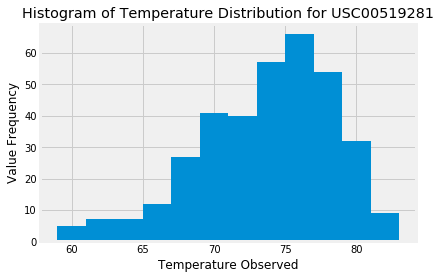

In [18]:
temps = temp_df.values
plt.hist(temps, bins = 12)
plt.xlabel('Temperature Observed')
plt.ylabel('Value Frequency')
plt.title(f'Histogram of Temperature Distribution for {most_active}')
plt.show()

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
